# Movie Ratings Capstome

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
# import prepare_stephen as ps
# import prepare_nick as pn
import wrangle as w
import datetime

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import scipy.stats as stats
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set default graph size
plt.rc('figure', figsize=(20.0, 10.0))
sns.set(rc = {'figure.figsize':(20,10)})


### Get Raw dirty data https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=links.csv

In [2]:
df = w.wrangle_df()

Using cached CSV


In [3]:
df.shape

(7282, 35)

In [4]:
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job...and the hotel's very unusual guests are about to place him in some outrageous predicaments. It seems that this evening's room service is serving up one unbelievable happening after another.,9.026586,98.0,0,1995-12-09,1995,tt0113101,0,0,0,0,0,0,1,1,0,0,0,0,0
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntertainmentNetworks,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, John and Rey get more than they bargained for. A wrong turn lands them directly in the path of Fallon, a vicious, wise-cracking drug lord. After accidentally witnessing Fallon murder a disloyal henchman, the four become his unwilling prey in a savage game of cat &amp; mouse as they are mercilessly stalked through the urban jungle in this taut suspense drama",5.538671,110.0,0,1993-10-15,1993,tt0107286,0,0,0,0,0,1,1,0,0,1,0,0,0
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by the evil Imperial forces in their effort to take over the galactic Empire. Venturesome Luke Skywalker and dashing captain Han Solo team together with the loveable robot duo R2-D2 and C-3PO to rescue the beautiful princess and restore peace and justice in the Empire.,42.149697,121.0,1,1977-05-25,1977,tt0076759,1,0,0,1,0,0,0,0,0,1,0,0,0
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexpectedly taken from his Great Barrier Reef home to a dentist's office aquarium. It's up to his worrisome father Marlin and a friendly but forgetful fish Dory to bring Nemo home -- meeting vegetarian sharks, surfer dude turtles, hypnotic jellyfish, hungry seagulls, and more along the way.",25.497794,100.0,1,2003-05-30,2003,tt0266543,0,0,0,0,0,0,0,0,1,0,0,0,0
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,"A man with a low IQ has accomplished great things in his life and been present during significant historic events - in each case, far exceeding what anyone imagined he could do. Yet, despite all the things he has attained, his one true love eludes him. 'Forrest Gump' is the story of a man who rose above his challenges, and who proved that determination, courage, and love are more important than ability.",48.307194,142.0,1,1994-07-06,1994,tt0109830,0,0,1,0,1,0,0,1,0,0,0,0,0


# Prepare Data

> ### Get prepared data
> - Handle missing values (Drop / fill by mean|mode)
> - Encode categorical data
> - Columns content split required:
    - cast
    - crew
    - production_companies
    - production_countries
> - Rename columns to ease readability
> - Drop duplicates & unnecessary columns
> - Convert release_date column from object data type to datetime format and index date
> - Data scaling
> - Feature engineering
> - Split the data into train, validate, test

### Split cast and crew columns into first name last name and get only first 3 names

In [5]:
# df.loc[df['cast'].str.split().str.len() == 2, 'last_name'] = df['cast'].str.split().str[-1]
# df
# df = df.drop(columns = 'first_name')

#### Initial Data Check

### Final check for nulls 

In [6]:
df.isnull().any()

title                   False
success                 False
success_rating          False
genres                   True
cast_actor_1            False
cast_actor_2            False
cast_actor_3            False
total_n_cast            False
budget                  False
revenue                 False
profit_amount           False
vote_average            False
vote_count              False
production_companies     True
production_countries     True
overview                False
popularity              False
runtime                 False
profitable              False
release_date            False
release_year            False
imdb_id                 False
is_genre_adventure      False
is_genre_horror         False
is_genre_drama          False
is_genre_scifi          False
is_genre_romance        False
is_genre_thriller       False
is_genre_crime          False
is_genre_comedy         False
is_genre_animation      False
is_genre_action         False
is_genre_mystery        False
is_genre_f

In [7]:
df['profit_amount'] = df.revenue - df.budget 

df['month'] = pd.DatetimeIndex(df['release_date']).month

df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job...and the hotel's very unusual guests are about to place him in some outrageous predicaments. It seems that this evening's room service is serving up one unbelievable happening after another.,9.026586,98.0,0,1995-12-09,1995,tt0113101,0,0,0,0,0,0,1,1,0,0,0,0,0,12
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntertainmentNetworks,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, John and Rey get more than they bargained for. A wrong turn lands them directly in the path of Fallon, a vicious, wise-cracking drug lord. After accidentally witnessing Fallon murder a disloyal henchman, the four become his unwilling prey in a savage game of cat &amp; mouse as they are mercilessly stalked through the urban jungle in this taut suspense drama",5.538671,110.0,0,1993-10-15,1993,tt0107286,0,0,0,0,0,1,1,0,0,1,0,0,0,10
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by the evil Imperial forces in their effort to take over the galactic Empire. Venturesome Luke Skywalker and dashing captain Han Solo team together with the loveable robot duo R2-D2 and C-3PO to rescue the beautiful princess and restore peace and justice in the Empire.,42.149697,121.0,1,1977-05-25,1977,tt0076759,1,0,0,1,0,0,0,0,0,1,0,0,0,5
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexpectedly taken from his Great Barrier Reef home to a dentist's office aquarium. It's up to his worrisome father Marlin and a friendly but forgetful fish Dory to bring Nemo home -- meeting vegetarian sharks, surfer dude turtles, hypnotic jellyfish, hungry seagulls, and more along the way.",25.497794,100.0,1,2003-05-30,2003,tt0266543,0,0,0,0,0,0,0,0,1,0,0,0,0,5
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,"A man with a low IQ has accomplished great things in his life and been present during significant historic events - in each case, far exceeding what anyone imagined he could do. Yet, despite all the things he has attained, his one true love eludes him. 'Forrest Gump' is the story of a man who rose above his challenges, and who proved that determination, courage, and love are more important than ability.",48.307194,142.0,1,1994-07-06,1994,tt0109830,0,0,1,0,1,0,0,1,0,0,0,0,0,7


> ### Split the data

In [8]:
# train, validate, test = ps.split_movies_data(df)

In [9]:
# print(f'DataFrame Shapes\n\tTrain {train.shape}, Validate: {validate.shape}, Test: {test.shape}')

# Explore Data

> ### Use train set

In [10]:
# train.hist(color = 'teal')
# plt.show()

> ### Visualizations

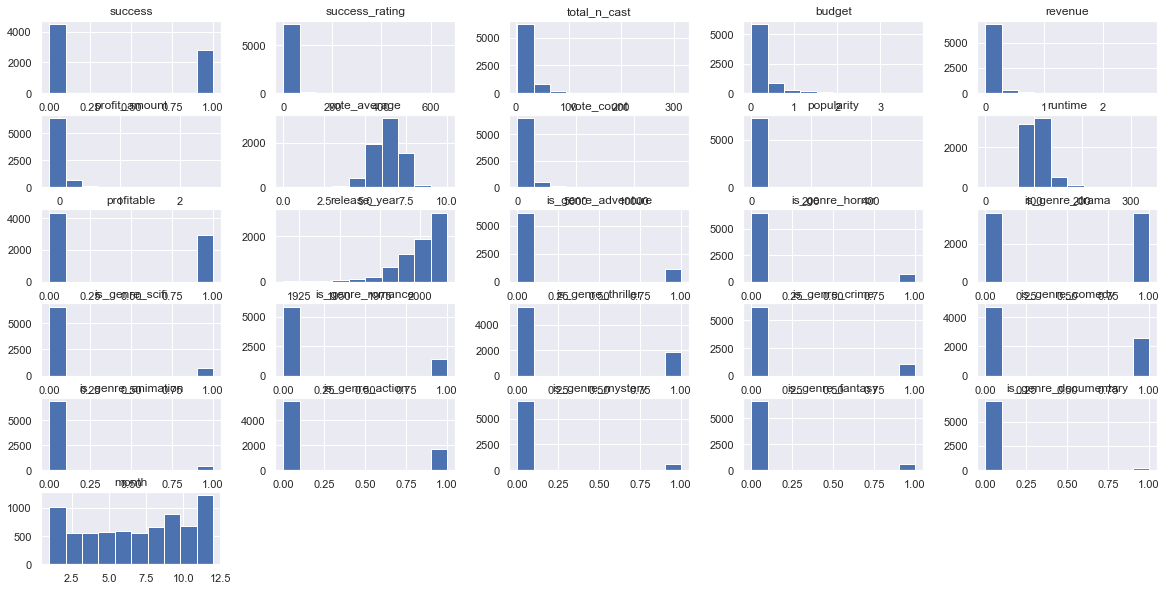

In [11]:
# Variable Distributions

df.hist()
plt.show()

### Correlation Heatmap

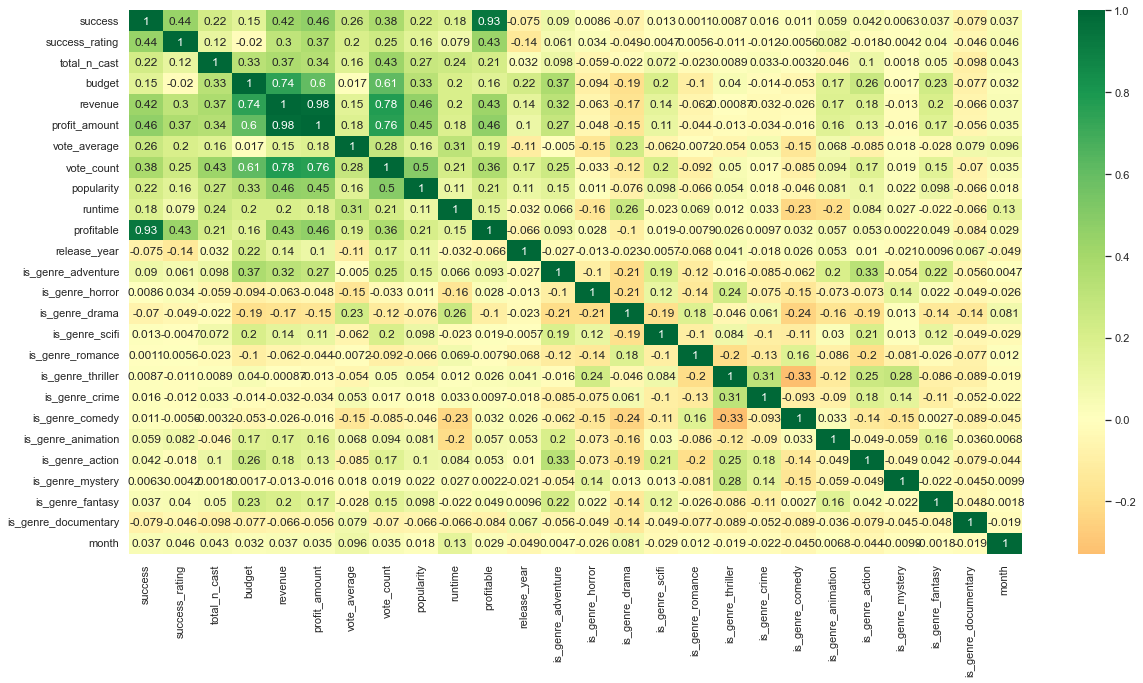

In [12]:
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
None

> ### Univariate Exploration

### Success vs Non-success Distribution

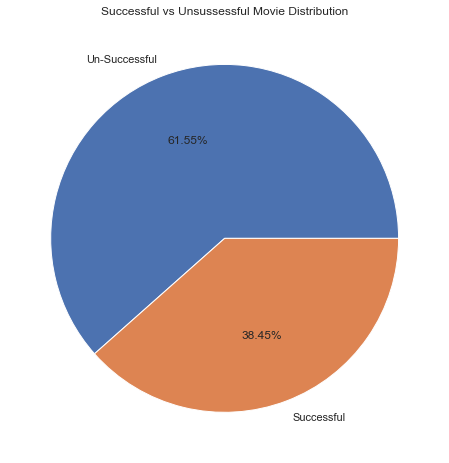

In [13]:
df1 = df.groupby(['success']).size()
labels = ['Un-Successful', 'Successful']

df1.plot(kind='pie', subplots = True, figsize=(8, 8), labels = labels, autopct='%1.2f%%')
plt.title("Successful vs Unsussessful Movie Distribution")
plt.ylabel("")
plt.show()

In [14]:
### Movie success by month (from 1990 )

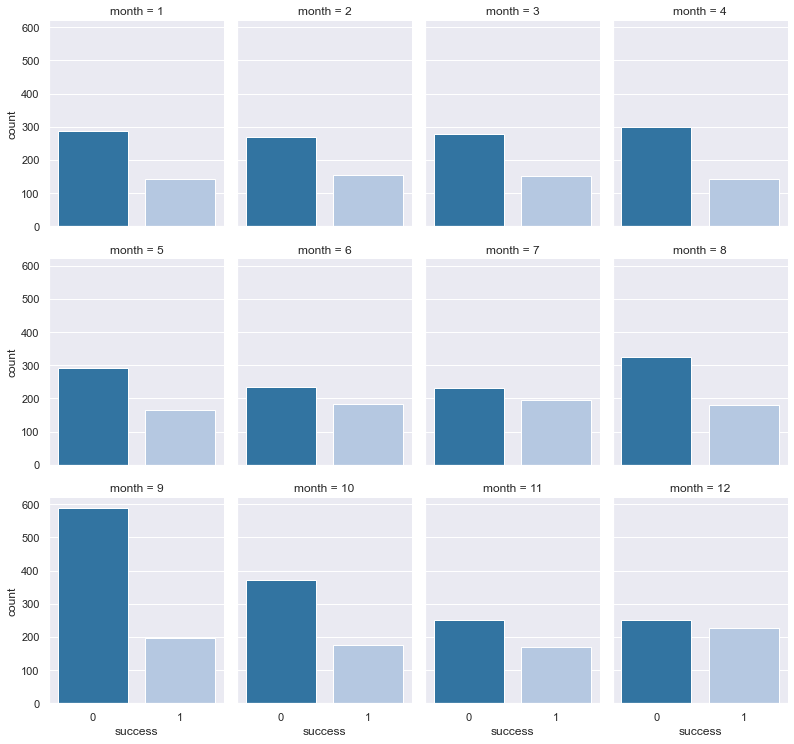

In [15]:
after_1990 = df[df.release_year >= 1990]

g = sns.catplot("success", col="month", col_wrap=4,
                data = after_1990,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')

plt.show()

### Movie Success from 1990 - 2017

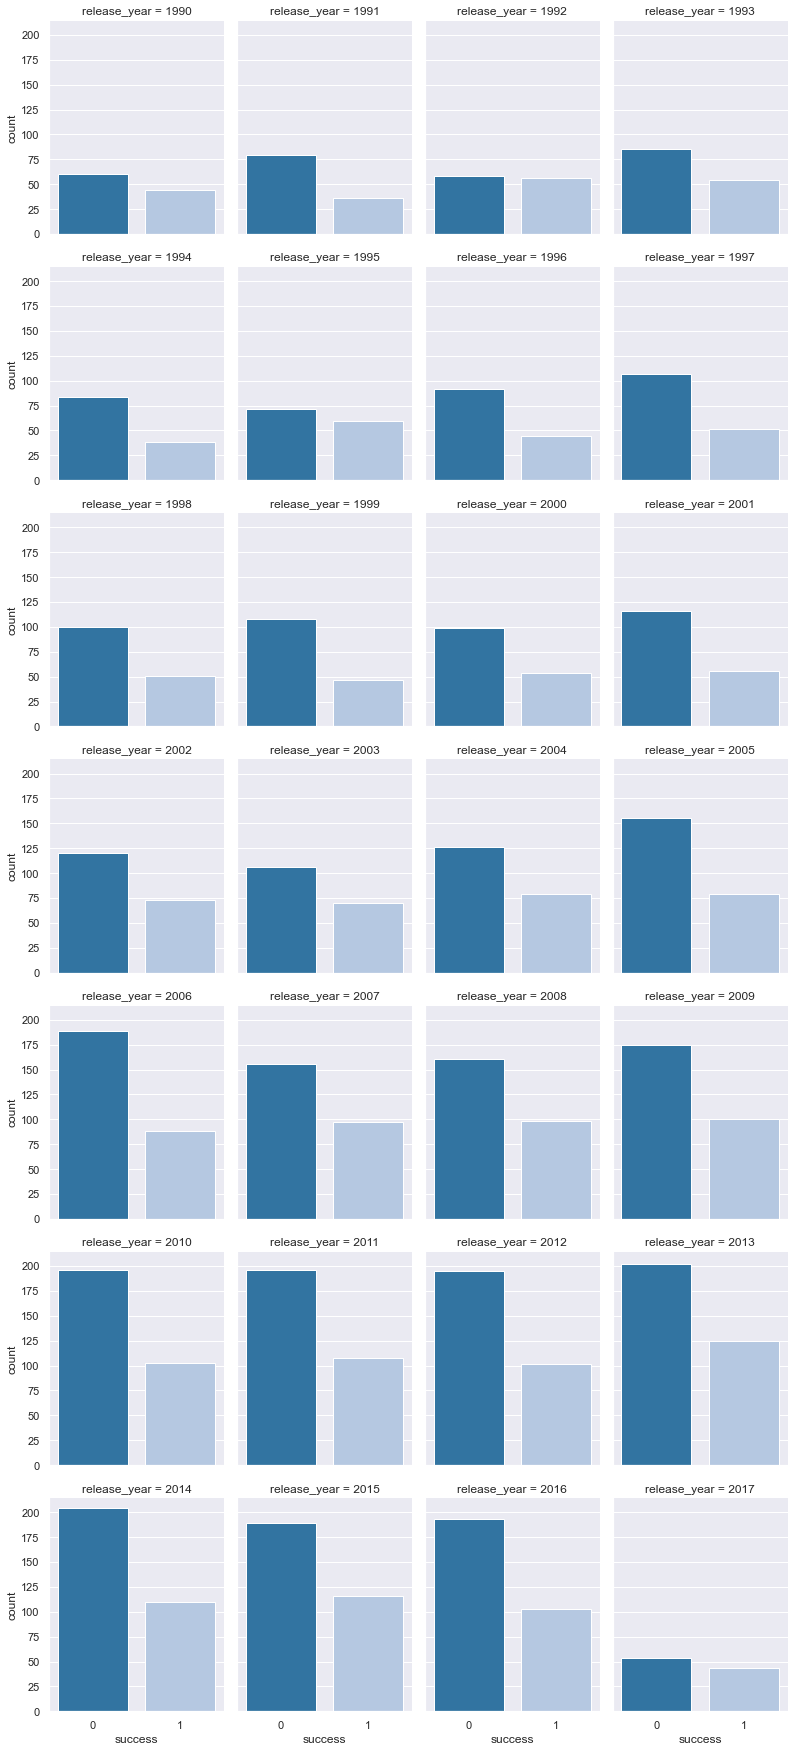

In [16]:
after_1990 = df[df.release_year >= 1990]

g = sns.catplot("success", col="release_year", col_wrap=4,
                data = after_1990,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')

plt.show()

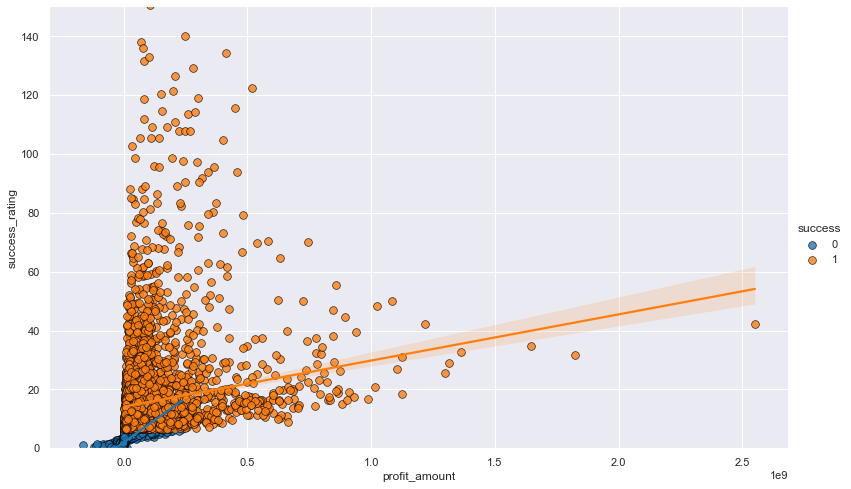

In [17]:
g = sns.lmplot(x="profit_amount", y="success_rating", hue="success", data=df, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))
g.set(ylim=(0, 150))
None

> ### Bi-Variate Exploration

> ### Multi-Variate Exploration

> ### Hypothesis testing

In [18]:
# Set alpha value

alpha = 0.05

####  (1). Is there a relationship between budget and revenue? 
 

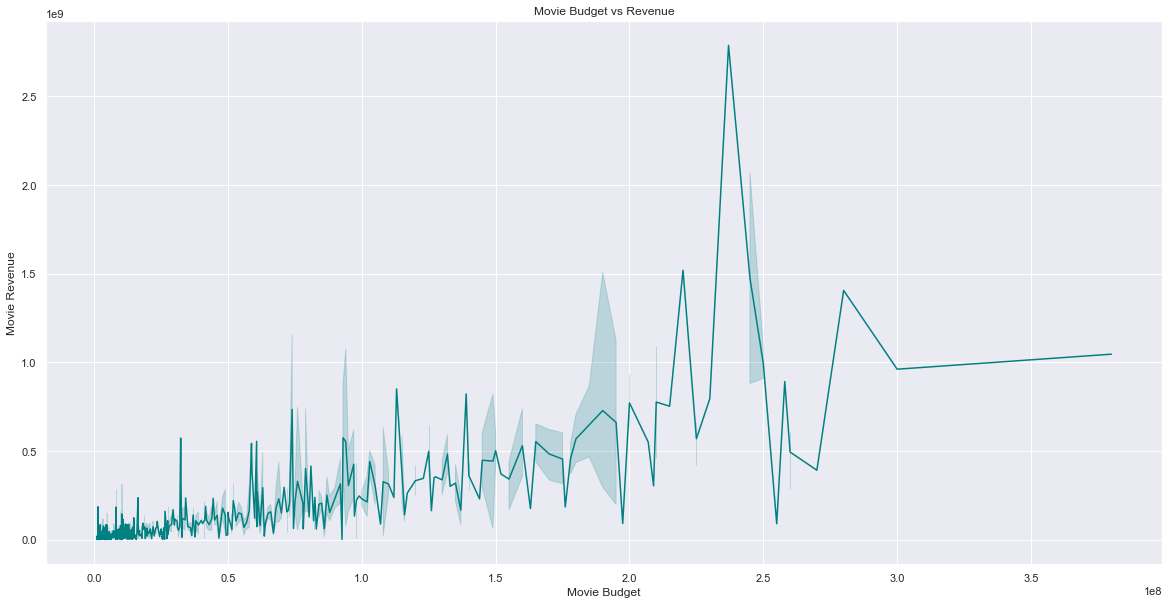

In [19]:
ax = sns.lineplot(x = df.budget, y = df.revenue, color = 'teal')
ax.set(xlabel = 'Movie Budget', ylabel = 'Movie Revenue')
ax.set(title = 'Movie Budget vs Revenue')
None

In [20]:
revenue = df.revenue.mean()
budget = df.budget.mean()

print(f'Mean Revenue: {revenue} \nMean Budget {budget}')
print('---------------------------------')
print(f'Mean Profit Difference {revenue - budget}')
print('---------------------------------')

Mean Revenue: 69878528.03172205 
Mean Budget 25517170.882175226
---------------------------------
Mean Profit Difference 44361357.14954683
---------------------------------


In [21]:
H0 = 'The is correlation between revenue and budgeting'
H1 = 'The is no correlation between revenue and budgeting'

x = df.budget
y = df.revenue

corr, p = stats.pearsonr(x, y)
corr, p

(0.7448859663853347, 0.0)

In [22]:
if (p < alpha):
    print(f'Reject --> {H0}')
else:
    print(f'Failed to Reject {H0}')

Reject --> The is correlation between revenue and budgeting


> NO CORRELATION BETWEEN REVENUE & BUDGET

#### (2). How runtime affect movie success?



In [23]:
df.success_rating.head()

id
5       3.493750
6       4.854775
11    285.487448
12     38.013564
13     50.537748
Name: success_rating, dtype: float64

In [24]:
# sns.relplot(x = 'runtime', y = 'budget', data = df, kind = 'line',  ci="sd");
# None

#### (3). What are the top 5 highest voted movies?


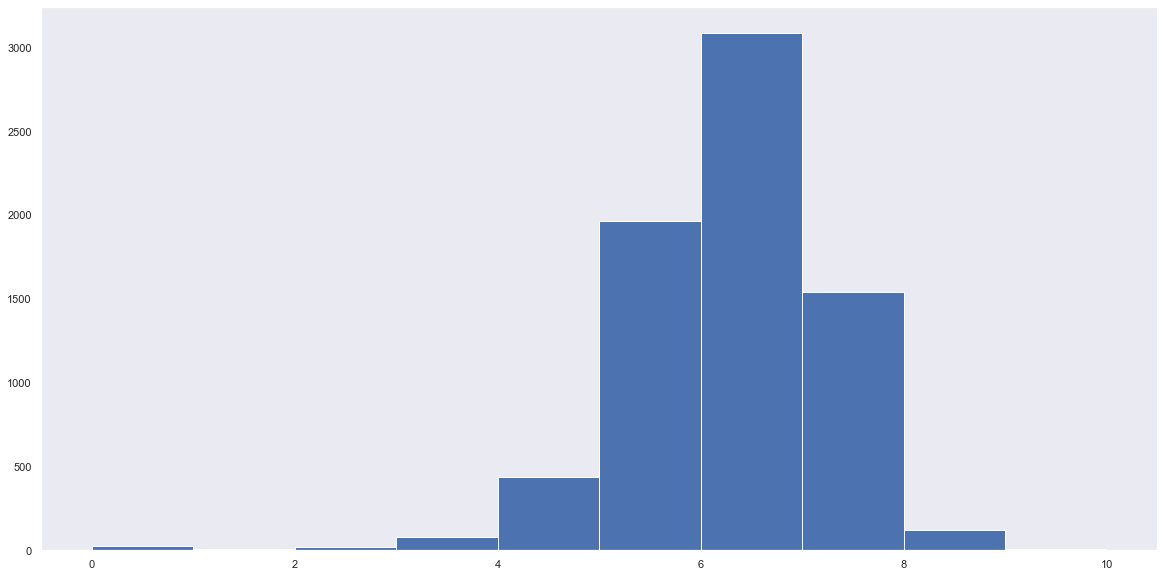

In [25]:
df.vote_average.hist(grid = False)
None

In [26]:
top_5 = df.vote_average.nlargest(n = 5)
top_5

id
78373     10.0
103162     9.5
19404      9.1
27915      9.0
161244     9.0
Name: vote_average, dtype: float64

#### (4). What are top 5 Highest profit movies?

In [27]:
df.head(1)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.49375,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job...and the hotel's very unusual guests are about to place him in some outrageous predicaments. It seems that this evening's room service is serving up one unbelievable happening after another.,9.026586,98.0,0,1995-12-09,1995,tt0113101,0,0,0,0,0,0,1,1,0,0,0,0,0,12


#### (5). Which genre has the highest profit? Or top 5?


In [28]:
top_5_most_profitable = df.nlargest(n = 5, columns = ['profit_amount'])
top_5_most_profitable

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,1,42.348837,Action Adventure Fantasy Science Fiction,Sam Worthington,Zoe Saldana,Sigourney Weaver,83.0,237000000.0,2.787965e+09,2.550965e+09,7.2,12114.0,IngeniousFilmPartners TwentiethCenturyFoxFilmCorporation DuneEntertainment LightstormEntertainment,UnitedStatesofAmerica UnitedKingdom,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",185.070892,162.0,1,2009-12-10,2009,tt0499549,1,0,0,1,0,0,0,0,0,1,0,1,0,12
140607,Star Wars: The Force Awakens,1,31.656484,Action Adventure Science Fiction Fantasy,Daisy Ridley,John Boyega,Adam Driver,84.0,245000000.0,2.068224e+09,1.823224e+09,7.5,7993.0,Lucasfilm TruenorthProductions BadRobot,UnitedStatesofAmerica,"Thirty years after defeating the Galactic Empire, Han Solo and his allies face a new threat from the evil Kylo Ren and his army of Stormtroopers.",31.626013,136.0,1,2015-12-15,2015,tt2488496,1,0,0,1,0,0,0,0,0,1,0,1,0,12
597,Titanic,1,34.594391,Drama Romance Thriller,Kate Winslet,Leonardo DiCaprio,Frances Fisher,136.0,200000000.0,1.845034e+09,1.645034e+09,7.5,7770.0,ParamountPictures TwentiethCenturyFoxFilmCorporation LightstormEntertainment,UnitedStatesofAmerica,"84 years later, a 101-year-old woman named Rose DeWitt Bukater tells the story to her granddaughter Lizzy Calvert, Brock Lovett, Lewis Bodine, Bobby Buell and Anatoly Mikailavich on the Keldysh about her life set in April 10th 1912, on a ship called Titanic when young Rose boards the departing ship with the upper-class passengers and her mother, Ruth DeWitt Bukater, and her fiancé, Caledon Hockley. Meanwhile, a drifter and artist named Jack Dawson and his best friend Fabrizio De Rossi win third-class tickets to the ship in a game. And she explains the whole story from departure until the death of Titanic on its first and last voyage April 15th, 1912 at 2:20 in the morning.",26.889070,194.0,1,1997-11-18,1997,tt0120338,0,0,1,0,1,1,0,0,0,0,0,0,0,11
135397,Jurassic World,1,32.793124,Action Adventure Science Fiction Thriller,Chris Pratt,Bryce Dallas Howard,Irrfan Khan,28.0,150000000.0,1.513529e+09,1.363529e+09,6.5,8842.0,UniversalStudios AmblinEntertainment LegendaryPictures FujiTelevisionNetwork Dentsu,UnitedStatesofAmerica,"Twenty-two years after the events of Jurassic Park, Isla Nublar now features a fully functioning dinosaur theme park, Jurassic World, as originally envisioned by John Hammond.",32.790475,124.0,1,2015-06-09,2015,tt0369610,1,0,0,1,0,1,0,0,0,1,0,0,0,6
168259,Furious 7,1,28.935843,Action,Vin Diesel,Paul Walker,Dwayne Johnson,52.0,190000000.0,1.506249e+09,1.316249e+09,7.3,4253.0,"UniversalPictures OriginalFilm FujiTelevisionNetwork Dentsu OneRaceFilms ChinaFilmCo. QuébecProductionServicesTaxCredit MediaRightsCapital(MRC) AbuDhabiFilmCommission ColoradoOfficeofFilm,Television&Media",Japan UnitedStatesofAmerica,Deckard Shaw seeks revenge against Dominic Toretto and his family for his comatose brother.,27.275687,137.0,1,2015-04-01,2015,tt2820852,0,0,0,0,0,0,0,0,0,1,0,0,0,4


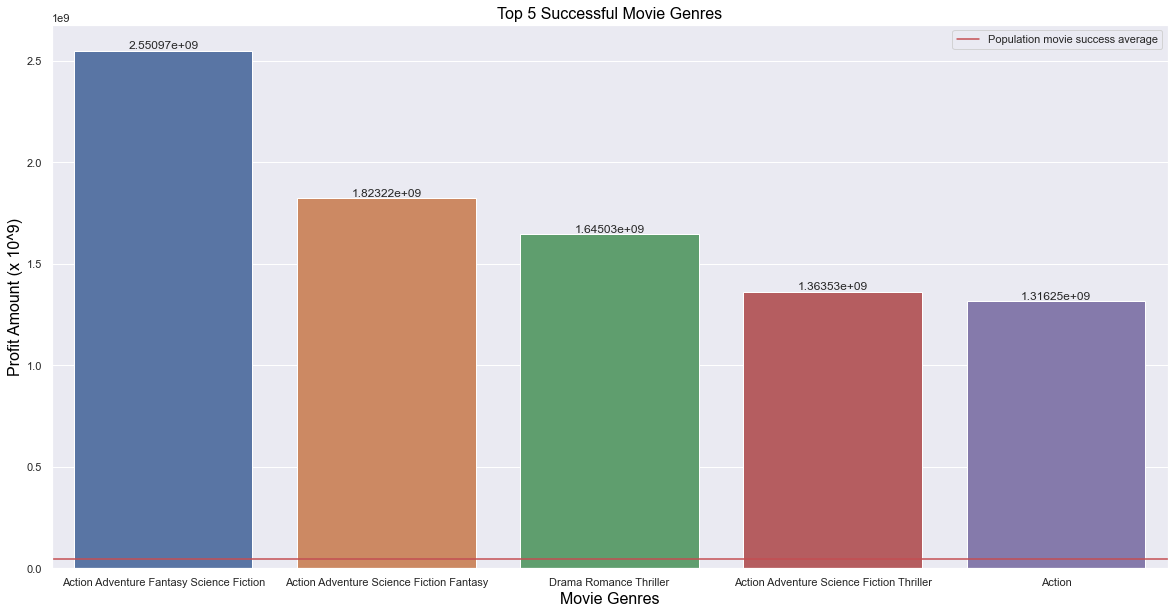

In [29]:
plt.title('Top 5 Successful Movie Genres', c = 'black', size = 16)
ax = sns.barplot(x = 'genres',  y = 'profit_amount', data = top_5_most_profitable)
ax.bar_label(ax.containers[0])  
overall_movie_profit_mean = df.profit_amount.mean()
plt.axhline(overall_movie_profit_mean, label="Population movie success average", color = 'r')
plt.ylabel('Profit Amount (x 10^9)', c = 'black', size = 16)
plt.xlabel('Movie Genres', c = 'black', size = 16)
plt.legend()
plt.show()

## [**NOTE: Genres appear as units***]



## - Avator has the highest profit 
####    - (1). Avator
####    - (2). Star Wars: The Force Awakens
####    - (3). Titanic
####    - (4). Jurassic World
####    - (5). Furious 7
    

### T-Test (One sample test)

In [30]:
H0 = 'Mean profit for top 5 successful movies = mean profit for all movies'
H1 = 'Mean profit for top 5 successful movies != mean profit for all movies'

overall_movie_profit_mean = df.profit_amount.mean()
top_5_movies_profit = top_5_most_profitable.profit_amount

t, p = stats.ttest_1samp(top_5_movies_profit, overall_movie_profit_mean)
t, p

(7.601626710091558, 0.001606980351671011)

In [31]:
if (p/2 < alpha):
    print(f'Reject --> {H0}')
elif t < 0:
    print(f'Failed to Reject {H0}')
else:
    print(f'Failed to Reject {H0}')

Reject --> Mean profit for top 5 successful movies = mean profit for all movies


#### Q5 CONCLUSION -- Top five mean profit NOT EQUAL to overal mean
#### - Top five profit accounts to 2.72% of overall profit

In [32]:
overall_movie_profit_mean = df.profit_amount.sum()

top_5_movies_profit = top_5_most_profitable.profit_amount.sum()

(top_5_movies_profit/overall_movie_profit_mean) * 100

2.6928606834325035

#### (6). How does a production company affect revenue? (Top 5 companies)

In [33]:
df['revenue'].nlargest(5)

id
19995     2.787965e+09
140607    2.068224e+09
597       1.845034e+09
24428     1.519558e+09
135397    1.513529e+09
Name: revenue, dtype: float64

In [34]:
# Most profitable production companies

top_5_production_companies = df.groupby(["production_companies"])\
.sum().sort_values("revenue", ascending=True).head(5)


top_5_production_companies

,success,success_rating,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,popularity,runtime,profitable,release_year,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,month
production_companies,,,,,,,,,,,,,,,,,,,,,,,,,,
Metro-Goldwyn-Mayer(MGM) AnErichvonStroheimProduction,0,4.062500e-07,8.0,8000000.0,1.0,-7999999.0,6.5,6.0,0.286719,137.0,0,1925,0,0,1,0,1,0,0,0,0,0,0,0,0,8
AlliedFilmmakers,0,3.062500e-07,24.0,8000000.0,1.0,-7999999.0,4.9,16.0,1.410322,84.0,0,1996,1,0,1,0,0,0,0,1,0,0,0,1,0,10
ShawBrothers,0,4.875000e-07,8.0,8000000.0,1.0,-7999999.0,7.8,12.0,2.291724,91.0,0,1997,0,0,1,0,0,0,0,0,0,0,0,0,0,12
CometFilmProduktionGmbH AvroraMedia CobblestonePictures,0,4.000000e-07,13.0,8000000.0,1.0,-7999999.0,6.4,36.0,2.466066,95.0,0,1995,0,0,0,0,0,1,0,0,0,0,0,0,0,9
CaravanPictures HollywoodPictures RogerBirnbaumProductions AlchemyFilmworks,0,4.625000e-07,9.0,8000000.0,1.0,-7999999.0,7.4,5.0,1.301573,115.0,0,1997,0,0,1,0,1,0,0,0,0,0,0,0,0,10


In [ ]:
#group data by product and display sales as line chart

df.groupby(['success','production_companies'])['revenue'].plot(legend=True)

None

In [ ]:
# ax = sns.barplot(x = 'production_companies',  y = 'revenue', data = df)
# ax.bar_label(ax.containers[0])
# ax.tick_params(axis='x', rotation=90)
# overall_mean_revenue = df.revenue.mean()
# plt.axhline(overall_mean_revenue, label="Population mean revenue", color = 'r')
# plt.ylabel('Revenue', c = 'black', size = 16)
# plt.xlabel('Production Companies', c = 'black', size = 16)
# plt.legend()
# plt.show()

In [127]:
df.columns

Index(['title', 'success', 'success_rating', 'genres', 'cast_actor_1',
       'cast_actor_2', 'cast_actor_3', 'total_n_cast', 'budget', 'revenue',
       'profit_amount', 'vote_average', 'vote_count', 'production_companies',
       'production_countries', 'overview', 'popularity', 'runtime',
       'profitable', 'release_date', 'release_year', 'runtime.1', 'imdb_id',
       'month'],
      dtype='object')

> ### Key exploration take-aways

# Modeling

### Test Model

## Conclusion & Recommendations